In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset_path = '/kaggle/input/plant-disease/Plant_leave_diseases_dataset_with_augmentation'
dataset = ImageFolder(root=dataset_path, transform=transform)

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
val_size = int(test_size/2)
test_size = val_size

In [14]:
# val_size
test_size

3830

In [10]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [2]:
model = resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 25)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    # Validation step
    model.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)

Epoch [1/10], Loss: 1.4886, Train Accuracy: 57.79%, Validation Accuracy: 71.20%
Epoch [2/10], Loss: 0.6501, Train Accuracy: 81.02%, Validation Accuracy: 85.56%
Epoch [3/10], Loss: 0.3930, Train Accuracy: 88.47%, Validation Accuracy: 90.55%
Epoch [4/10], Loss: 0.2827, Train Accuracy: 91.68%, Validation Accuracy: 92.69%
Epoch [5/10], Loss: 0.2106, Train Accuracy: 93.76%, Validation Accuracy: 94.23%
Epoch [6/10], Loss: 0.1652, Train Accuracy: 95.04%, Validation Accuracy: 94.10%
Epoch [7/10], Loss: 0.1331, Train Accuracy: 96.17%, Validation Accuracy: 95.14%
Epoch [8/10], Loss: 0.1065, Train Accuracy: 96.93%, Validation Accuracy: 94.05%
Epoch [9/10], Loss: 0.0882, Train Accuracy: 97.57%, Validation Accuracy: 93.47%
Epoch [10/10], Loss: 0.0741, Train Accuracy: 97.92%, Validation Accuracy: 97.52%


In [15]:
test_predictions = []
test_labels = []

In [16]:
from sklearn.metrics import accuracy_score
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.21%


In [17]:
test_accuracy = accuracy_score(test_labels, test_predictions) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.21%


In [18]:
model_path = 'resnet18_trained_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")

Trained model saved to resnet18_trained_model.pth


In [19]:
print(train_losses,
train_accuracies,
test_labels,
test_predictions)

[1.4886371137453769, 0.6500965601342705, 0.3929563487621339, 0.2827406149660869, 0.21055146692503468, 0.165176429219995, 0.13307748386531384, 0.10645912054125103, 0.08824917102827533, 0.07414779703605275] [57.79286483663544, 81.01641805659823, 88.4714560825146, 91.67999477755654, 93.75918007637823, 95.04194274896368, 96.17129614518393, 96.92855044553971, 97.56503574109736, 97.91755067402161] [12, 22, 12, 22, 22, 16, 3, 12, 3, 1, 23, 22, 21, 15, 12, 18, 3, 8, 20, 13, 22, 18, 3, 24, 7, 23, 13, 0, 10, 22, 3, 12, 14, 9, 21, 13, 21, 21, 14, 12, 12, 21, 17, 21, 12, 22, 10, 12, 6, 6, 12, 23, 13, 12, 13, 21, 20, 21, 19, 5, 9, 21, 21, 18, 5, 21, 1, 19, 24, 12, 19, 21, 12, 21, 6, 11, 2, 22, 12, 4, 20, 3, 2, 1, 17, 6, 6, 5, 7, 23, 21, 10, 23, 8, 13, 16, 12, 1, 22, 4, 14, 2, 22, 21, 23, 12, 22, 2, 5, 23, 8, 12, 7, 12, 12, 16, 19, 17, 7, 2, 22, 20, 21, 12, 7, 3, 17, 22, 4, 15, 18, 21, 13, 17, 21, 3, 21, 23, 3, 0, 10, 10, 8, 21, 22, 15, 7, 12, 19, 3, 9, 21, 13, 21, 21, 12, 14, 0, 13, 9, 21, 20, 9, 8

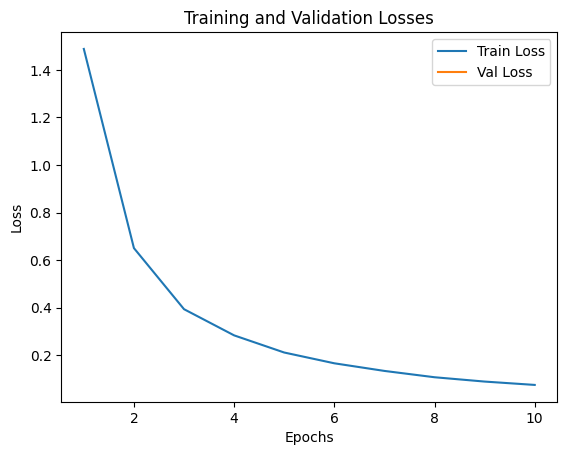

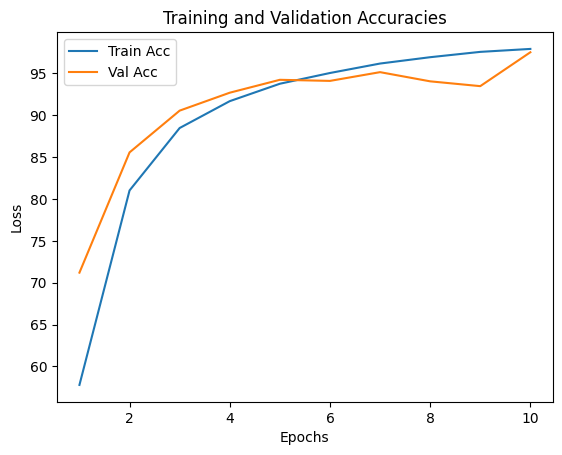

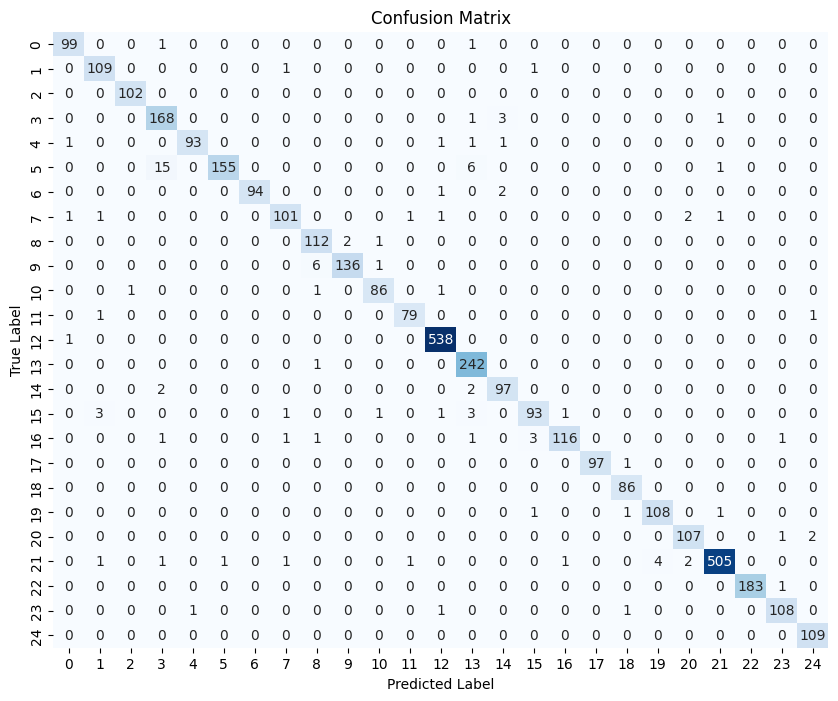

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       101
           1       0.95      0.98      0.96       111
           2       0.99      1.00      1.00       102
           3       0.89      0.97      0.93       173
           4       0.99      0.96      0.97        97
           5       0.99      0.88      0.93       177
           6       1.00      0.97      0.98        97
           7       0.96      0.94      0.95       108
           8       0.93      0.97      0.95       115
           9       0.99      0.95      0.97       143
          10       0.97      0.97      0.97        89
          11       0.98      0.98      0.98        81
          12       0.99      1.00      0.99       539
          13       0.94      1.00      0.97       243
          14       0.94      0.96      0.95       101
          15       0.95      0.90      0.93       103
          16       0.98      0.94      0.96       124
    

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import numpy as np


plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels, test_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))


In [3]:
from torchvision.models import mobilenet_v2

mobilenet_v2_model = mobilenet_v2(pretrained=False)
num_ftrs = mobilenet_v2_model.classifier[1].in_features
mobilenet_v2_model.classifier[1] = nn.Linear(num_ftrs, 25)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model = mobilenet_v2_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)

In [5]:
torch.cuda.is_available()

True

In [6]:
train_losses_1 = []
train_accuracies_1 = []
val_losses_1 = []
val_accuracies_1 = []

In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    mobilenet_v2_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    # Validation step
    mobilenet_v2_model.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = mobilenet_v2_model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss = val_running_loss / len(val_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    train_losses_1.append(epoch_loss)
    train_accuracies_1.append(epoch_accuracy)
    val_accuracies_1.append(val_accuracy)
    val_losses_1.append(val_loss)


Epoch [1/10], Loss: 1.0423, Train Accuracy: 68.6947%, Validation Loss: 0.8926, Validation Accuracy: 72.48%
Epoch [2/10], Loss: 0.6248, Train Accuracy: 80.9675%, Validation Loss: 0.7688, Validation Accuracy: 75.14%
Epoch [3/10], Loss: 0.4008, Train Accuracy: 87.9916%, Validation Loss: 0.4763, Validation Accuracy: 85.27%
Epoch [4/10], Loss: 0.2833, Train Accuracy: 91.5984%, Validation Loss: 0.2230, Validation Accuracy: 93.37%
Epoch [5/10], Loss: 0.2164, Train Accuracy: 93.6547%, Validation Loss: 0.1911, Validation Accuracy: 93.79%
Epoch [6/10], Loss: 0.1732, Train Accuracy: 94.8069%, Validation Loss: 0.1194, Validation Accuracy: 96.40%
Epoch [7/10], Loss: 0.1338, Train Accuracy: 96.0114%, Validation Loss: 0.1111, Validation Accuracy: 96.24%
Epoch [8/10], Loss: 0.1079, Train Accuracy: 96.8959%, Validation Loss: 0.3630, Validation Accuracy: 88.51%
Epoch [9/10], Loss: 0.0934, Train Accuracy: 97.3920%, Validation Loss: 0.0858, Validation Accuracy: 97.34%
Epoch [10/10], Loss: 0.0752, Train Ac

In [9]:
# Testing loop
mobilenet_v2_model.eval()
test_predictions_1 = []
test_labels_1 = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2_model(images)
        _, predicted = outputs.max(1)
        test_predictions_1.extend(predicted.cpu().numpy())
        test_labels_1.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels_1, test_predictions_1) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.31%


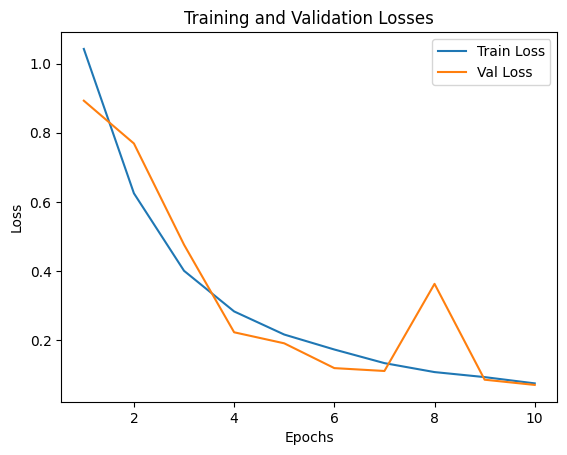

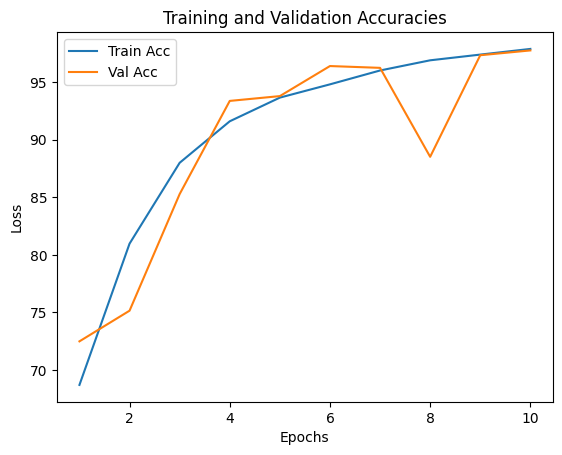

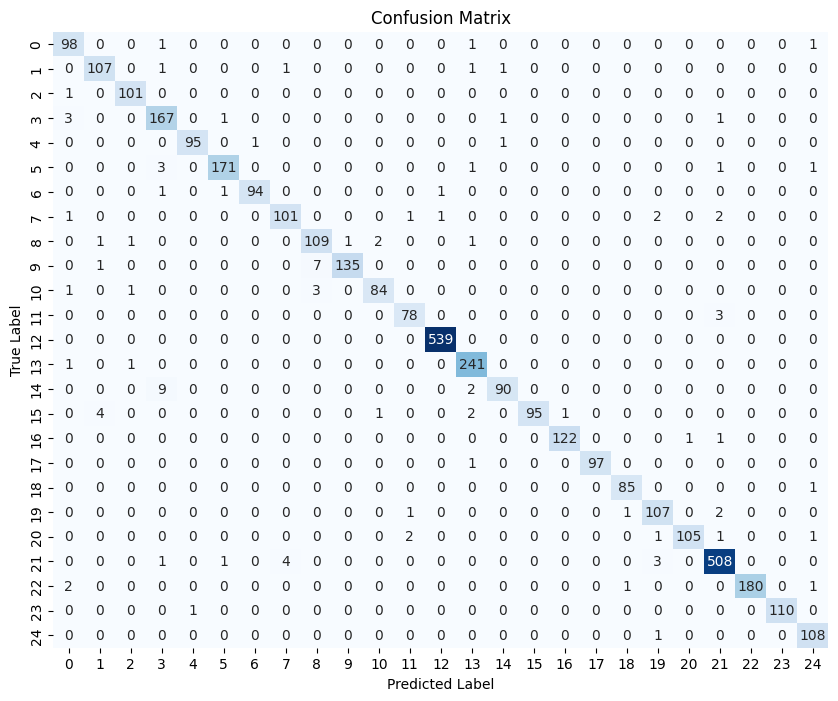

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       101
           1       0.95      0.98      0.96       111
           2       0.99      1.00      1.00       102
           3       0.89      0.97      0.93       173
           4       0.99      0.96      0.97        97
           5       0.99      0.88      0.93       177
           6       1.00      0.97      0.98        97
           7       0.96      0.94      0.95       108
           8       0.93      0.97      0.95       115
           9       0.99      0.95      0.97       143
          10       0.97      0.97      0.97        89
          11       0.98      0.98      0.98        81
          12       0.99      1.00      0.99       539
          13       0.94      1.00      0.97       243
          14       0.94      0.96      0.95       101
          15       0.95      0.90      0.93       103
          16       0.98      0.94      0.96       124
    

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import numpy as np


plt.plot(range(1, len(train_losses_1) + 1), train_losses_1, label='Train Loss')
plt.plot(range(1, len(val_losses_1) + 1), val_losses_1, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.plot(range(1, len(train_accuracies_1) + 1), train_accuracies_1, label='Train Acc')
plt.plot(range(1, len(val_accuracies_1) + 1), val_accuracies_1, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels_1, test_predictions_1), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_1, test_predictions_2))


In [7]:
from torchvision.models import inception_v3

inception_v3_model = inception_v3(pretrained=False)
num_ftrs = inception_v3_model.fc.in_features
inception_v3_model.fc = nn.Linear(inception_v3_model.fc.in_features, 25)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inception_v3_model = inception_v3_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception_v3_model.parameters(), lr=0.001, momentum=0.9)

In [9]:
train_losses_2 = []
train_accuracies_2 = []
val_losses_2 = []
val_accuracies_2 = []

In [20]:
torch.cuda.empty_cache()

In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    inception_v3_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_output = inception_v3_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    # Validation step
    inception_v3_model.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = inception_v3_model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss = val_running_loss / len(val_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    train_losses_2.append(epoch_loss)
    train_accuracies_2.append(epoch_accuracy)
    val_accuracies_2.append(val_accuracy)
    val_losses_2.append(val_loss)


Epoch [1/10], Loss: 1.6543, Train Accuracy: 52.6847%, Validation Loss: 1.3966, Validation Accuracy: 58.75%
Epoch [2/10], Loss: 1.2006, Train Accuracy: 64.9182%, Validation Loss: 1.0486, Validation Accuracy: 68.36%
Epoch [3/10], Loss: 0.9345, Train Accuracy: 72.1774%, Validation Loss: 0.7587, Validation Accuracy: 77.57%
Epoch [4/10], Loss: 0.7297, Train Accuracy: 78.0951%, Validation Loss: 0.5865, Validation Accuracy: 82.56%
Epoch [5/10], Loss: 0.5879, Train Accuracy: 82.6452%, Validation Loss: 0.4870, Validation Accuracy: 86.21%
Epoch [6/10], Loss: 0.4739, Train Accuracy: 86.1801%, Validation Loss: 0.3658, Validation Accuracy: 89.58%
Epoch [7/10], Loss: 0.3885, Train Accuracy: 88.6934%, Validation Loss: 0.3145, Validation Accuracy: 90.99%
Epoch [8/10], Loss: 0.3357, Train Accuracy: 90.0708%, Validation Loss: 0.2677, Validation Accuracy: 92.32%
Epoch [9/10], Loss: 0.2867, Train Accuracy: 91.4417%, Validation Loss: 0.2277, Validation Accuracy: 93.19%
Epoch [10/10], Loss: 0.2522, Train Ac

In [13]:
# Testing loop
inception_v3_model.eval()
test_predictions_2 = []
test_labels_2 = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v3_model(images)
        _, predicted = outputs.max(1)
        test_predictions_2.extend(predicted.cpu().numpy())
        test_labels_2.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels_2, test_predictions_2) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 94.18%


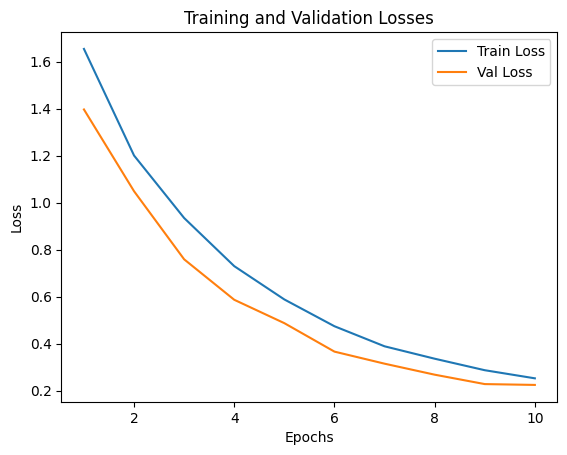

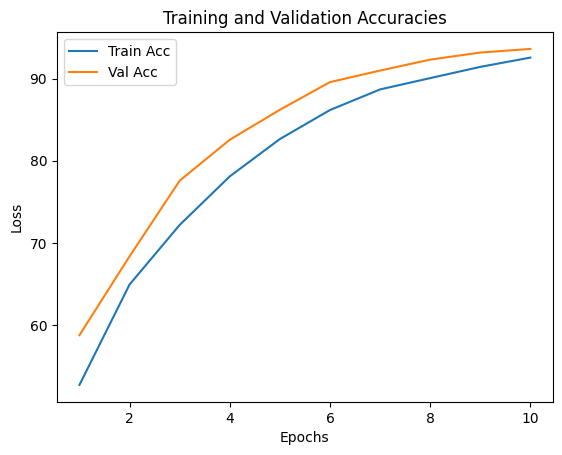

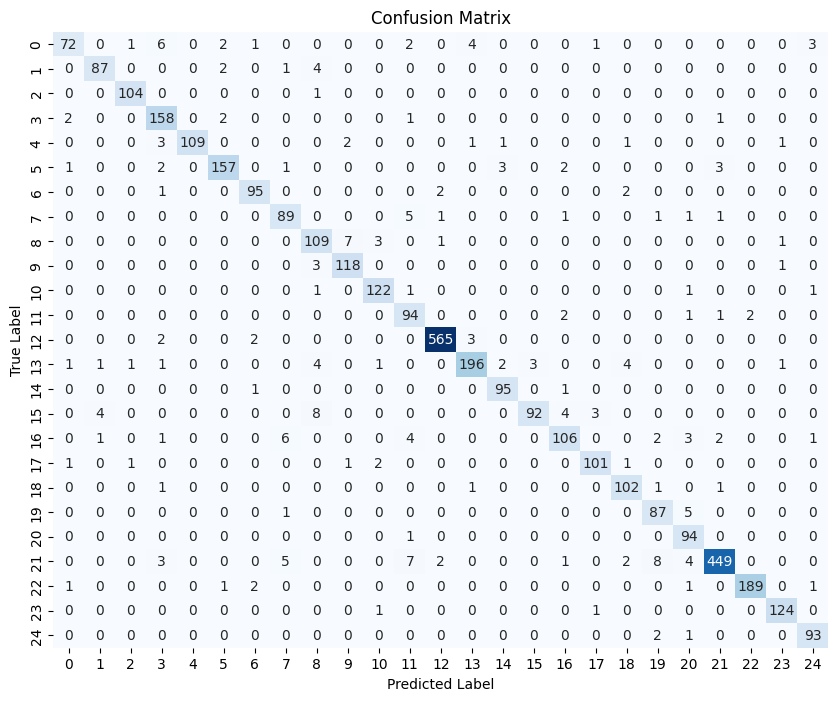

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85        92
           1       0.94      0.93      0.93        94
           2       0.97      0.99      0.98       105
           3       0.89      0.96      0.92       164
           4       1.00      0.92      0.96       118
           5       0.96      0.93      0.94       169
           6       0.94      0.95      0.95       100
           7       0.86      0.90      0.88        99
           8       0.84      0.90      0.87       121
           9       0.92      0.97      0.94       122
          10       0.95      0.97      0.96       126
          11       0.82      0.94      0.87       100
          12       0.99      0.99      0.99       572
          13       0.96      0.91      0.93       215
          14       0.94      0.98      0.96        97
          15       0.97      0.83      0.89       111
          16       0.91      0.84      0.87       126
    

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import numpy as np


plt.plot(range(1, len(train_losses_2) + 1), train_losses_2, label='Train Loss')
plt.plot(range(1, len(val_losses_2) + 1), val_losses_2, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.plot(range(1, len(train_accuracies_2) + 1), train_accuracies_2, label='Train Acc')
plt.plot(range(1, len(val_accuracies_2) + 1), val_accuracies_2, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels_2, test_predictions_2), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_2, test_predictions_2))


In [4]:
import torch
import torchvision.models as models

# Define the path to your saved model file
model_path = '/kaggle/working/resnet18_trained_model.pth'

# Load the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# If the model was saved with DataParallel, you might need to unwrap it
# Uncomment the following lines if your model was saved with DataParallel
if isinstance(model, torch.nn.DataParallel):
    model = model.module

# Ensure to set the model to evaluation mode
model.eval()

# If needed, move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

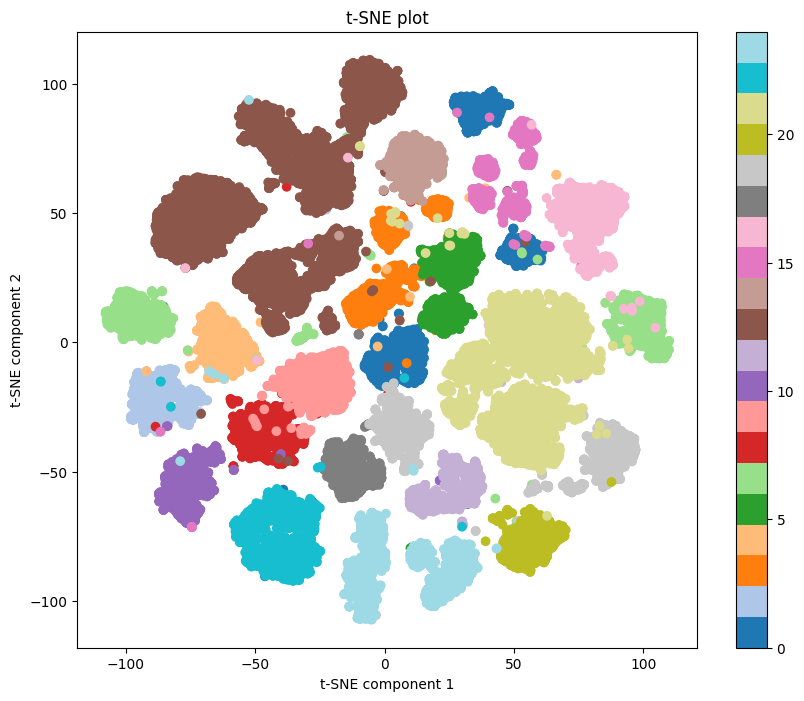

In [5]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='/kaggle/input/plant-disease/Plant_leave_diseases_dataset_with_augmentation', transform=transform)

data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

model.fc = nn.Identity()

model = model.to(device)

def extract_features(model, data_loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return np.array(features), np.array(labels)

features, labels = extract_features(model, data_loader)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE plot')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

In [1]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)
    fig = plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        indices = np.where(np.array(labels) == label)[0]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label, alpha=0.5)
    plt.title('t-SNE Visualization of Image Data')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Class')
    plt.show()

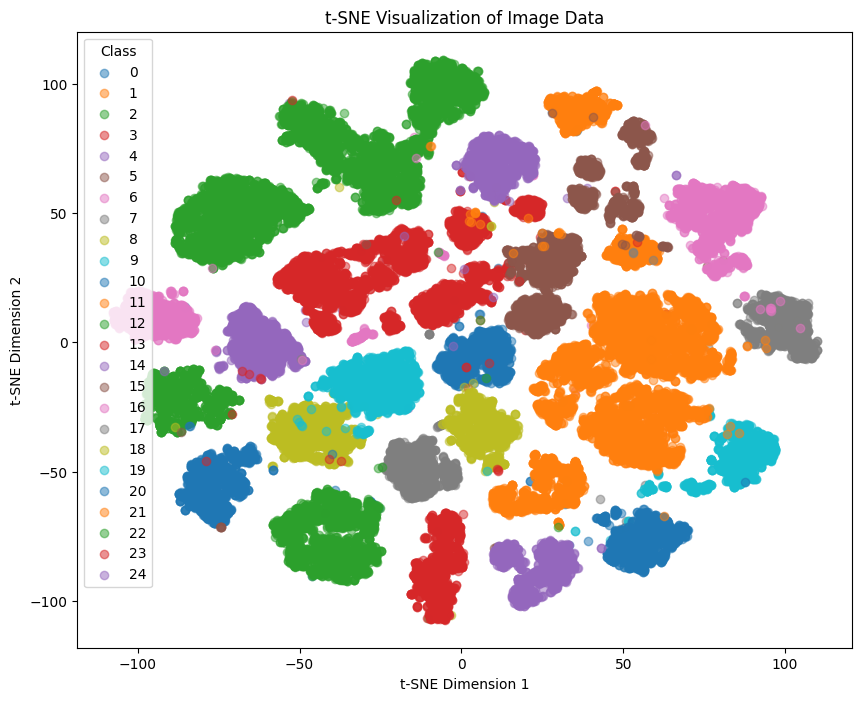

In [7]:
plot_tsne(features, labels)

In [17]:
import time
import torch
import torchvision.models as models

model_path = '/kaggle/working/resnet18_trained_model.pth'

state_dict = torch.load(model_path)

model.load_state_dict(state_dict)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

start_time = time.time()

# Run one epoch (loop over data loader)
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

end_time = time.time()
epoch_time = end_time - start_time
print(f"Wall clock time for one epoch: {epoch_time} seconds")



Wall clock time for one epoch: 402.63770961761475 seconds


In [4]:
pip install ptflops

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  11.19 M, 100.000% Params, 1.82 GMac, 99.828% MACs, 
  (conv1): Conv2d(9.41 k, 0.084% Params, 118.01 MMac, 6.467% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 1.61 MMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 802.82 KMac, 0.044% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    147.97 k, 1.322% Params, 464.83 MMac, 25.473% MACs, 
    (0): BasicBlock(
      73.98 k, 0.661% Params, 232.42 MMac, 12.736% MACs, 
      (conv1): Conv2d(36.86 k, 0.329% Params, 115.61 MMac, 6.335% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 401.41 KMac, 0.022% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0,